In [1]:
# ===========================================   BASELINE: TFIDF + NAIVE BAYES   ================================================

In [2]:
# ========================================
# 1. Imports
# ========================================


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, mean_absolute_error

import torch
from torch.utils.data import Dataset
from transformers import (
    BertTokenizerFast,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments
)


# --------------------------------------------
# משתנה גלובלי לשמירת ה‐batch_size שייבחר ע"י החיפוש
# --------------------------------------------
BEST_BATCH_SIZE = None


C:\Users\Gleb\anaconda3\envs\py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# ========================================
# 2. Load Dataset and define 4 columns
# ========================================

DATA_PATH = r"C:\Users\Gleb\Desktop\N.L.P\CHATGPT_DATASET.csv"
df = pd.read_csv(DATA_PATH, encoding='cp1252', engine='python')
df.dropna(subset=["review"], inplace=True)

labels = ["difficulty","interest","usefulness","teaching_quality"]
assert all(c in df.columns for c in labels)

In [4]:
# ========================================
# 3. Split Train / Val / Test
# ========================================
X_train, X_temp, y_train, y_temp = train_test_split(
    df["review"], df[labels], test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

In [5]:
# ========================================
# 4. Baseline: TF-IDF + Naive Bayes w/ strict/full-match 
# ========================================
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import ParameterGrid, KFold
import pandas as pd
import numpy as np

# 5.1 Define the grid of hyperparameters
param_grid = {
    "tfidf__max_features": [3000, 5000],
    "tfidf__ngram_range":    [(1, 1), (1, 2)],
    "clf__estimator__alpha": [0.5, 1.0, 1.5]
}
grid = list(ParameterGrid(param_grid))
n_folds = 3
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# 5.2 Evaluate every combination
records = []
for cfg in grid:
    # build pipeline for this config
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            max_features=cfg["tfidf__max_features"],
            ngram_range=cfg["tfidf__ngram_range"])),
        ("clf", MultiOutputClassifier(
            MultinomialNB(alpha=cfg["clf__estimator__alpha"])))
    ])
    strict_scores = []
    three_of_four = []
    for train_idx, val_idx in kf.split(X_train):
        Xtr, Xv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        ytr, yv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        pipe.fit(Xtr, ytr)
        preds = pipe.predict(Xv)
        correct = (preds == yv.values)
        strict_scores.append( correct.all(axis=1).mean() )
        # exactly 3 out of 4 correct:
        three_of_four.append(
            ((correct.sum(axis=1) >= 3) ).mean()
        )
    records.append({
        "config":        cfg,
        "strict_match":  np.mean(strict_scores),
        "three_of_four": np.mean(three_of_four)
    })

res_df = pd.DataFrame(records)

# 5.3 Find best/worst by strict full-match
best = res_df.loc[res_df["strict_match"].idxmax()]
worst = res_df.loc[res_df["strict_match"].idxmin()]

# 5.4 How many total model runs?
total_runs = len(grid) * n_folds
print(f"🔢 Tried {total_runs} model-runs ({len(grid)} configs × {n_folds} folds)\n")

# 5.5 Report best configuration
print("✅ Best configuration on Validation Set (highest 4-of-4 match):")
print(f"   strict_match = {best.strict_match:.3f}")
print(f"   three_of_four = {best.three_of_four:.3f}")
print("   params:", best.config, "\n")

# 5.6 Report worst configuration
print("❌ Worst configuration on Validation Set:")
print(f"   strict_match = {worst.strict_match:.3f}")
print(f"   three_of_four = {worst.three_of_four:.3f}")
print("   params:", worst.config, "\n")

# 5.7 Finally—per-label accuracy of the *best* model on the validation set
#      (so you also get the >0.9-level numbers for each label)
best_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=best.config["tfidf__max_features"],
        ngram_range= best.config["tfidf__ngram_range"]
    )),
    ("clf", MultiOutputClassifier(
        MultinomialNB(alpha=best.config["clf__estimator__alpha"])
    ))
])
best_pipe.fit(X_train, y_train)
y_pred_val = best_pipe.predict(X_val)

acc_per_label = {
    lab: (y_pred_val[:, i] == y_val[lab]).mean()
    for i, lab in enumerate(y_val.columns)
}
print("--- Baseline per-label accuracy on Validation set ---")
for lab, acc in acc_per_label.items():
    print(f"{lab:17s}: {acc:.3f}")

# ========================================
# 5.7 Final evaluation on TEST set
# ========================================
# Predict on X_test
y_pred_test = best_pipe.predict(X_test)

# בניית מטריצה בוליאנית של נכונות
correct_test = (y_pred_test == y_test.values)

# 5.7.1 Strict 4-of-4 match
strict_test = correct_test.all(axis=1).mean()

# 5.7.2 At least 3-of-4 correct
three_plus_test = (correct_test.sum(axis=1) >= 3).mean()

# 5.7.3 Per-label accuracy on Test set
acc_per_label_test = {
    lab: (y_pred_test[:, i] == y_test[lab]).mean()
    for i, lab in enumerate(y_test.columns)
}

print("\n\n\n\n--- Final Test set evaluation ---")
print(f"Strict 4-of-4 match on Test set     :    {strict_test:.3f}")
print(f"At least 3-of-4 correct on Test set :    {three_plus_test:.3f}")
print("\nBaseline per-label accuracy on Test set:")
for lab, acc in acc_per_label_test.items():
    print(f"{lab:17s}: {acc:.3f}")

🔢 Tried 36 model-runs (12 configs × 3 folds)

✅ Best configuration on Validation Set (highest 4-of-4 match):
   strict_match = 0.804
   three_of_four = 0.945
   params: {'clf__estimator__alpha': 0.5, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)} 

❌ Worst configuration on Validation Set:
   strict_match = 0.586
   three_of_four = 0.873
   params: {'clf__estimator__alpha': 1.5, 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 2)} 

--- Baseline per-label accuracy on Validation set ---
difficulty       : 0.929
interest         : 0.914
usefulness       : 0.934
teaching_quality : 0.929




--- Final Test set evaluation ---
Strict 4-of-4 match on Test set     :    0.777
At least 3-of-4 correct on Test set :    0.929

Baseline per-label accuracy on Test set:
difficulty       : 0.937
interest         : 0.906
usefulness       : 0.917
teaching_quality : 0.937


In [6]:
# ==========================================   BASELINE Rsults Exploration    =================================================

C:\Users\Gleb\AppData\Local\Temp\ipykernel_41228\3257484707.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('length_bin')['strict_match'].mean().reset_index()


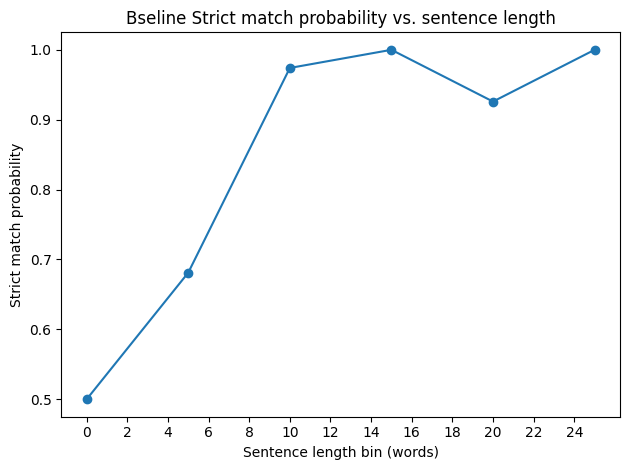

In [7]:
# ========================================
# Guessing all 4 labels vs sentence length
# ========================================

import sys
import pandas as pd
import matplotlib.pyplot as plt

# Ensure required variables exist
if not all(var in globals() for var in ['best_pipe', 'X_test', 'y_test']):
    print("Please run your baseline training cell first to define best_pipe, X_test, and y_test.")
else:
    # Predict on test set
    y_pred_test = best_pipe.predict(X_test)

    # Compute strict 4-of-4 match mask
    strict_mask = (y_pred_test == y_test.values).all(axis=1)

    # Compute sentence lengths (number of words)
    lengths = X_test.str.split().str.len()

    # Create DataFrame for analysis
    df = pd.DataFrame({
        'length': lengths,
        'strict_match': strict_mask
    })

    # Bin lengths into intervals of 5 words
    max_len = df['length'].max()
    bins = list(range(0, int(max_len) + 5, 5))
    labels = bins[:-1]
    df['length_bin'] = pd.cut(df['length'], bins=bins, labels=labels, right=False)

    # Compute mean strict match probability per length bin
    grouped = df.groupby('length_bin')['strict_match'].mean().reset_index()
    grouped['length_bin'] = grouped['length_bin'].astype(int)

    # Plot the relationship with X-axis ticks every 2 words
    fig, ax = plt.subplots()
    ax.plot(grouped['length_bin'], grouped['strict_match'], marker='o')
    ax.set_xlabel('Sentence length bin (words)')
    ax.set_ylabel('Strict match probability')
    ax.set_title('Bseline Strict match probability vs. sentence length')
    ax.set_xticks(range(int(grouped['length_bin'].min()), int(grouped['length_bin'].max()) + 1, 2))
    plt.tight_layout()
    plt.show()


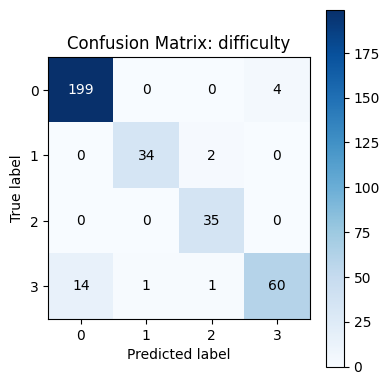

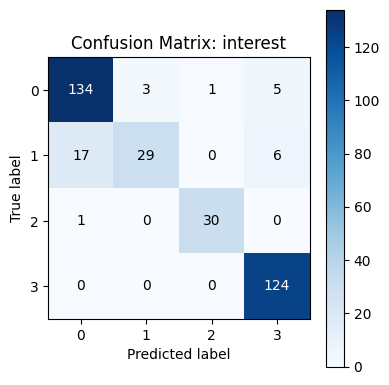

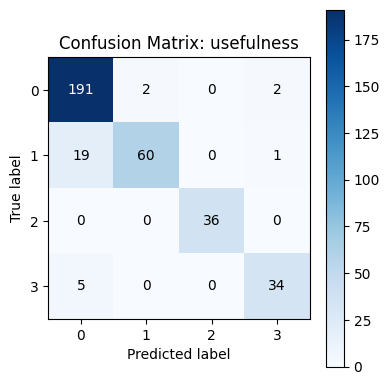

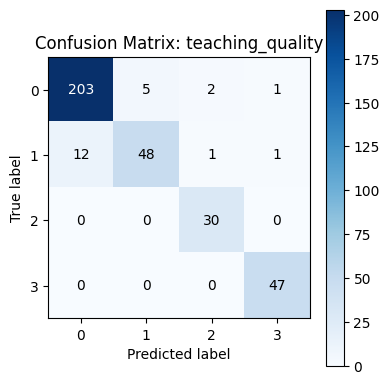

In [8]:
# ========================================
# Confusion Matrix
# ========================================

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------
# 1. הגדרת שמות הלייבלים ועל אילו ערכים נבחן
# --------------------------------------------
labels_cols = ['difficulty', 'interest', 'usefulness', 'teaching_quality']
num_classes = [0, 1, 2, 3]

# --------------------------------------------
# 2. בניית הפייפליין של ה-Baseline עם הפרמטרים הטובים
#    (לדוגמה: alpha=0.5, max_features=3000, ngram_range=(1,2))
# --------------------------------------------
best_params = {
    'tfidf__max_features': 3000,
    'tfidf__ngram_range': (1, 2),
    'clf__estimator__alpha': 0.5
}

baseline_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()), 
    ('clf', MultiOutputClassifier(MultinomialNB()))
])
baseline_pipeline.set_params(**best_params)

# --------------------------------------------
# 3. איחוד Train + Validation (אם רוצים לאמן על כל ה־Train+Val)
#    או פשוט להמשיך עם X_train, y_train בלבד (במקרה של re-train).
#    כאן נניח שהשתמשנו ב־Grid Search על Train+Val, וכעת נבצע fit על Train+Val
# --------------------------------------------
# לדוגמה, אם X_train ו־y_train כרגע הם Train בלבד:
# צריך לאחד X_train, X_val ו־y_train, y_val כדי לאמן על כל 80%:
import pandas as pd
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)

baseline_pipeline.fit(X_trainval, y_trainval)

# --------------------------------------------
# 4. חיזוי על ה־Test set
# --------------------------------------------
y_pred = baseline_pipeline.predict(X_test)  # תוצאה בצורת מטריצה (700, 4)

# --------------------------------------------
# 5. חישוב ושרטוט מטריצת הבלבול לכל לייבל
#    (הקוד לוגיקה לקוח מהחלק “Plot a confusion matrix for each label”)
#    ראה דוגמה בקובץ: :contentReference[oaicite:0]{index=0}
# --------------------------------------------

for i, lab in enumerate(labels_cols):
    cm = confusion_matrix(y_test[lab], y_pred[:, i], labels=num_classes)

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix: {lab}")
    plt.colorbar()
    tick_marks = np.arange(len(num_classes))
    plt.xticks(tick_marks, num_classes)
    plt.yticks(tick_marks, num_classes)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # כתיבת הערכים בתוך התא של ה־confusion matrix
    thresh = cm.max() / 2
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            plt.text(
                col, row, format(cm[row, col], 'd'),
                ha="center", va="center",
                color="white" if cm[row, col] > thresh else "black"
            )

    plt.tight_layout()
    plt.show()
